# Compare the Extract the Throughput

- Extract throuput from the files generated by **MLfit_bouguer_linearfit.ipynb**.

- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation : October 12th 2020 : update with titles


In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline


In [3]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [4]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits',
 'comptable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits',
 'thermtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [5]:
import time
from datetime import datetime,date
import dateutil.parser
import pytz

import logging
import coloredlogs

import coloredlogs
import configparser
import argparse


In [6]:
from scipy import interpolate
from scipy.interpolate import UnivariateSpline

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel,WhiteKernel)

# Initialisation

In [8]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [9]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2020-10-12 17:02:55,123 MacBook-Pro-de-admin.local __main__[55794] INFO LA time:08:02:55
2020-10-12 17:02:55,126 MacBook-Pro-de-admin.local __main__[55794] INFO NY time:11:02:55
2020-10-12 17:02:55,129 MacBook-Pro-de-admin.local __main__[55794] INFO London time:16:02:55
2020-10-12 17:02:55,131 MacBook-Pro-de-admin.local __main__[55794] INFO Paris time:17:02:55
2020-10-12 17:02:55,132 MacBook-Pro-de-admin.local __main__[55794] INFO ************************ START *********************


In [10]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""

In [11]:
# config file
# --------------
configfile = "config/default.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2020-10-12 17:02:55,145 MacBook-Pro-de-admin.local __main__[55794] INFO Configuration file : config/default.ini


# Configuration

In [12]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

2020-10-12 17:02:55,158 MacBook-Pro-de-admin.local __main__[55794] INFO 1) Configuration


In [13]:
config_section = config.sections()

In [14]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [15]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT   = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT  = bool(int(config['GENERAL']['FLAG_PRINT']))
    inputdir    = config['GENERAL']['inputdir']
    inputfile   = config['GENERAL']['inputfile']
    target      = config['GENERAL']['object']
    sedfilename = config['GENERAL']['sedfilename']
    WLMINSEL      = float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      = float(config['GENERAL']['WLMAXSEL'])
    normalisation_factor = float(config['GENERAL']['normalisation_factor'])
    NPOINTSVIEW       =    int(config['GENERAL']['NPOINTSVIEW']) 
    NPOINTSSAVE       =    int(config['GENERAL']['NPOINTSSAVE']) 
    outputfile_linearfit =  config['GENERAL']['outputfile_linearfit']
    outputfile_gp        =  config['GENERAL']['outputfile_gp']
    holodatadir      =  config['GENERAL']['holodatadir']
    

else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)

In [16]:
msg=f" Object observed {target}"
logger.info(msg)

2020-10-12 17:02:55,224 MacBook-Pro-de-admin.local __main__[55794] INFO  Object observed HD116405


In [17]:
# SELECT THE INPUT FILE
inputfilename1 = outputfile_linearfit
inputfilename2 = outputfile_gp

## throuputdata from bouguer lines

The file has been generated by **MLfit_bouguer_linearfit.ipynb** or **MLfit_bouguer_gp.ipynb**     

In [18]:
df1=pd.read_csv(inputfilename1,index_col=0)

In [19]:
# decode the data
Y1=df1["throu"]
EY1=df1["errthrou"]
wl1=df1["wavelength"]

In [20]:
df2=pd.read_csv(inputfilename2,index_col=0)

In [21]:
# decode the data
Y2=df2["throu"]
EY2=df2["errthrou"]
wl2=df2["wavelength"]

## Plot

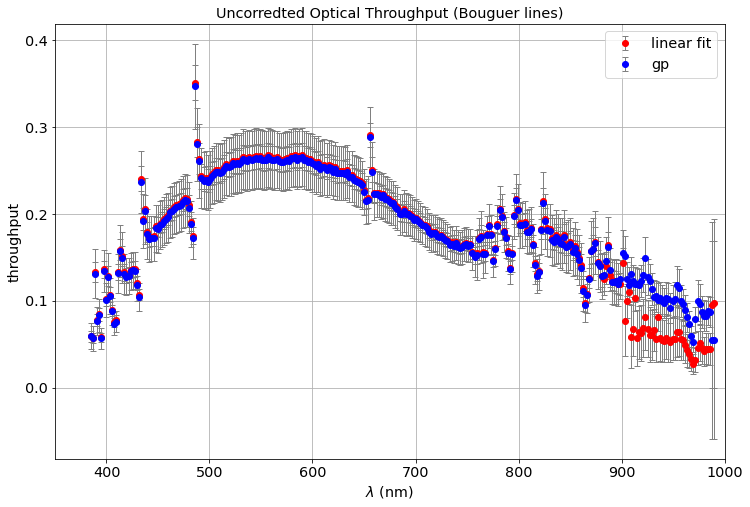

In [29]:
fig=plt.figure()
ax=fig.add_subplot(111)


# pic du midi throughput
ax.errorbar(wl1,Y1,yerr=EY1,  fmt = 'o', color="r",capsize = 3, ecolor = 'grey', elinewidth = 1, capthick = 1,label="linear fit")

ax.errorbar(wl2,Y2,yerr=EY2,  fmt = 'o', color="b",capsize = 3, ecolor = 'grey', elinewidth = 1, capthick = 1,label="gp")

ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"Uncorredted Optical Throughput (Bouguer lines)"
ax.set_title(title)
ax.grid()
ax.legend()
ax.set_xlim(350,1000)
plt.show()

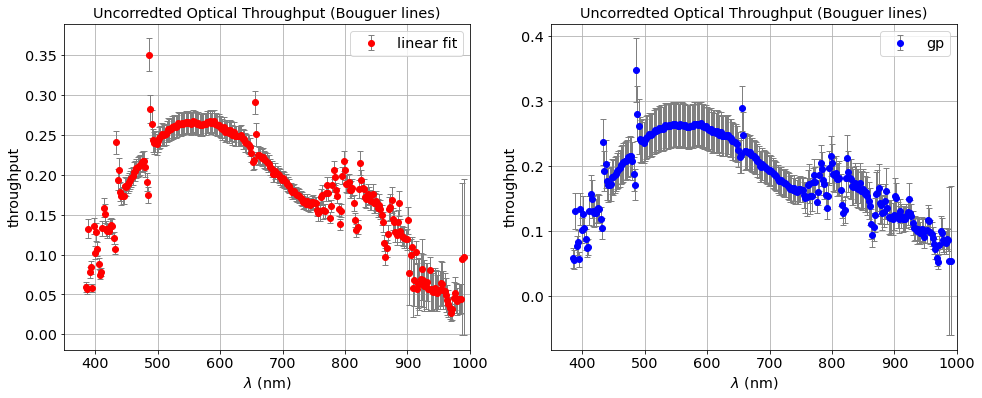

In [28]:
fig=plt.figure(figsize=(16,6))
ax=fig.add_subplot(121)


# pic du midi throughput
ax.errorbar(wl1,Y1,yerr=EY1,  fmt = 'o', color="r",capsize = 3, ecolor = 'grey', elinewidth = 1, capthick = 1,label="linear fit")


ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"Uncorredted Optical Throughput (Bouguer lines)"
ax.set_title(title)
ax.grid()
ax.legend()
ax.set_xlim(350,1000)


ax=fig.add_subplot(122)


# pic du midi throughput


ax.errorbar(wl2,Y2,yerr=EY2,  fmt = 'o', color="b",capsize = 3, ecolor = 'grey', elinewidth = 1, capthick = 1,label="gp")

ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"Uncorredted Optical Throughput (Bouguer lines)"
ax.set_title(title)
ax.grid()
ax.legend()
ax.set_xlim(350,1000)
plt.show()

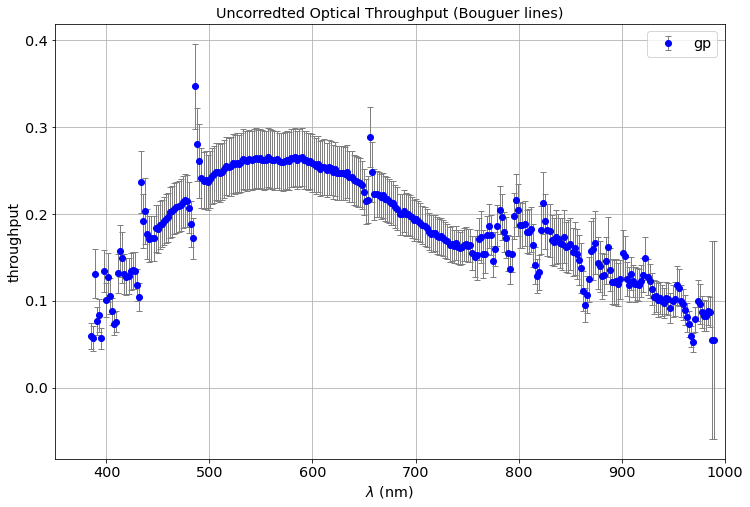

In [30]:
fig=plt.figure()
ax=fig.add_subplot(111)


# pic du midi throughput


ax.errorbar(wl2,Y2,yerr=EY2,  fmt = 'o', color="b",capsize = 3, ecolor = 'grey', elinewidth = 1, capthick = 1,label="gp")

ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"Uncorredted Optical Throughput (Bouguer lines)"
ax.set_title(title)
ax.grid()
ax.legend()
ax.set_xlim(350,1000)
plt.show()